In [2]:
from __future__ import annotations

import matplotlib
import rapidjson as json
import os
import toml
from collections import Counter
from pathlib import Path

import numpy as np
import pandas as pd
from pandas import DataFrame as DF
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
fm = matplotlib.font_manager
fm._get_fontconfig_fonts.cache_clear()
sns.set(context='notebook', style='ticks', font='Source Han Sans CN', rc={'axes.unicode_minus': False})
plt.rcParams["font.sans-serif"] = ["Source Han Sans CN"] #设置字体
plt.rcParams["axes.unicode_minus"] = False #该语句解决图像中的“-”负号的乱码问题

In [45]:
from hypy_utils.tqdm_utils import tq, pmap, smap
import orjson


def _helper(p: Path):
    return orjson.loads(p.read_text())

def load_data():
    dir = Path(toml.loads(Path('config.toml').read_text())['index_path'])
    files = [(dir / f) for f in tq(os.listdir(dir), 'Loading file list') if f.endswith('.json')]
    return smap(_helper, files, desc='Loading json')


data = load_data()
raw_data = data
print(f'一共有 {len(data)} 個訂單')

Loading json: 100%|██████████| 159601/159601 [00:19<00:00, 8298.62it/s] 


一共有 159601 個訂單


In [46]:
delivery = json.loads(Path('data/delivery.json').read_text())
delivery: dict[int, dict] = {d['id']: d for d in delivery}

for d in data:
    # package_time: 用户提交包裹的时间
    # pay_time: 用户支付的时间
    # delivery_time: Superbuy 创建第三方配送单的时间
    # receive_time: 用户收到包裹的时间
    d['route'] = d['delivery_name'] + ' to ' + d['area_name']
    d['duration'] = ((d['receive_time'] - d['pay_time']) / 60 / 60 / 24) if d['receive_time'] != 0 else None
    d['real_package_price'] = float(d['real_package_price'])
    d['package_price'] = float(d['package_price'])
    d['price_diff'] = d['package_price'] - d['real_package_price']
    del d['package_items']

    # d['delivery'] = delivery.get(d['delivery_id']) or {'id': d['delivery_id'], 'name': 'Unknown'}

data_df = DF(data)

In [55]:
import time

def canada_test():
    # Filter only 加拿大海运专线
    canada = [d for d in raw_data if d['delivery_name'] == '加拿大海运专线']
    print(f'一共有 {len(canada)} 個訂單')
    
    # Get average days from now since pay
    now = time.time()
    for d in canada:
        d['days'] = (now - d['pay_time']) / 60 / 60 / 24
        
    df = pd.DataFrame(canada)
    
    print(df['days'].describe())
    
    return df['days']
    
canada_test()

一共有 84 個訂單
count    84.000000
mean     14.780678
std       6.396797
min       2.143327
25%      10.305676
50%      16.249253
75%      20.318014
max      23.712007
Name: days, dtype: float64


0      4.562181
1      4.347956
2      2.640225
3      4.731706
4      4.241706
        ...    
79    22.624739
80    23.246128
81    23.164056
82    23.190607
83    23.712007
Name: days, Length: 84, dtype: float64

In [32]:
# Filter out receive_time = 0 (haven't been received yet)
data = [d for d in data if d['receive_time'] != 0]
# Filter out real_pacakge_price = 0 (haven't been packaged yet)
data = [d for d in data if d['real_package_price'] != 0]

data_df = DF(data)

In [36]:
def graph_price_diff():
    # Filter out routes with < 30 orders
    df = data_df.groupby('route').filter(lambda x: len(x) > 30)
    
    # Calculate average price diff for each route
    # routes = {d['route'] for d in data}
    # diffs = DF([{'route': r, 'price_diff': df[df['route'] == r]['price_diff'].mean()} for r in routes])
    # A better way to do this
    diffs = df.groupby('route')['price_diff'].mean()
    
    # Sort by price diff
    diffs = diffs.sort_values()
    diffs = diffs.reset_index()
    
    return diffs
    

graph_price_diff()

,route,price_diff
0,中国大陆中通 to 中国,3.089872
1,中国大陆顺丰 to 中国,5.475552
2,E特快 to 菲律宾,12.210000
3,荷邮平邮空运小包 to 英国,12.602813
4,EUB-A to 澳大利亚,14.113023
...,...,...
267,香港DHL (21KG+) to 美国,679.191111
268,香港UPS (20KG+) to 美国,766.642115
269,香港DHL-A（大货） to 美国,882.404783
270,香港DHL (30KG+) to 美国,894.713924


所有運輸：
> 總訂單量： 88882
> 時間中數： 20.04 天
> 平均時間： 38.90 天
> 時間分佈：


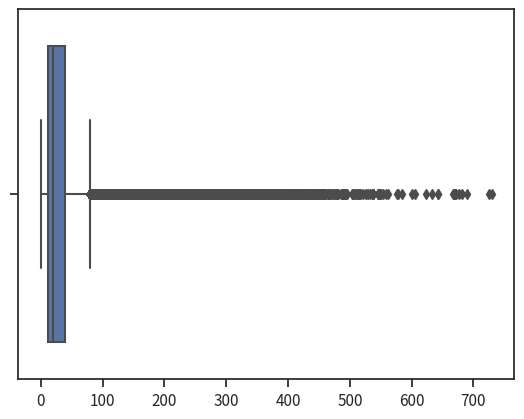

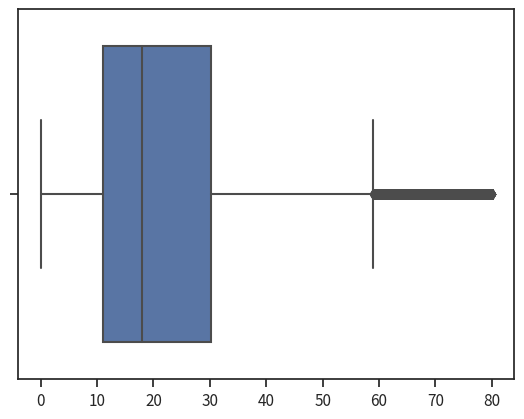

In [37]:
def overall_stats():
    durations = [d["duration"] for d in data if d["duration"]]

    print('所有運輸：')
    print(f'> 總訂單量： {len(data)}')
    print(f'> 時間中數： {np.median(durations):.2f} 天')
    print(f'> 平均時間： {np.mean(durations):.2f} 天')
    print(f'> 時間分佈：')

    sns.boxplot(x=durations)
    plt.show()
    sns.boxplot(x=[d for d in durations if d < 80])
    plt.show()

overall_stats()

總共有送往 90 個國家的訂單
集運目的國家統計： 前 30 國家的訂單數


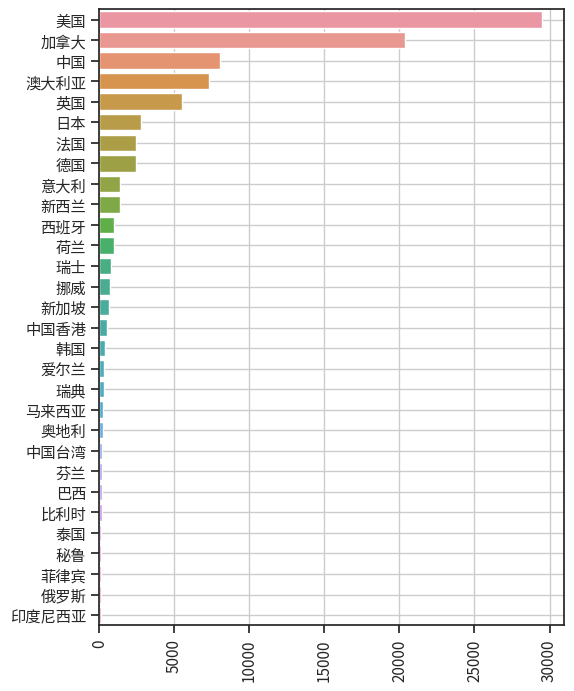

In [38]:
def bars(lst: list[tuple[str, int]]):
    plt.figure(figsize=(6, 8))
    sns.barplot(x=[v for k, v in lst], y=[k for k, v in lst], orient='h')
    plt.xticks(rotation=90)
    plt.grid()
    plt.show()


def country_stats():
    countries = sorted(Counter([d['area_name'] for d in data]).items(), key=lambda x: -x[1])
    print(f'總共有送往 {len(countries)} 個國家的訂單')
    countries = countries[:30]
    print('集運目的國家統計： 前 30 國家的訂單數')
    bars(countries)


country_stats()

正在分析送往全球的訂單數據...
總共有 154 個快遞公司
前 50 快遞公司的訂單數（圖1）和運輸時間天數（圖2,3）


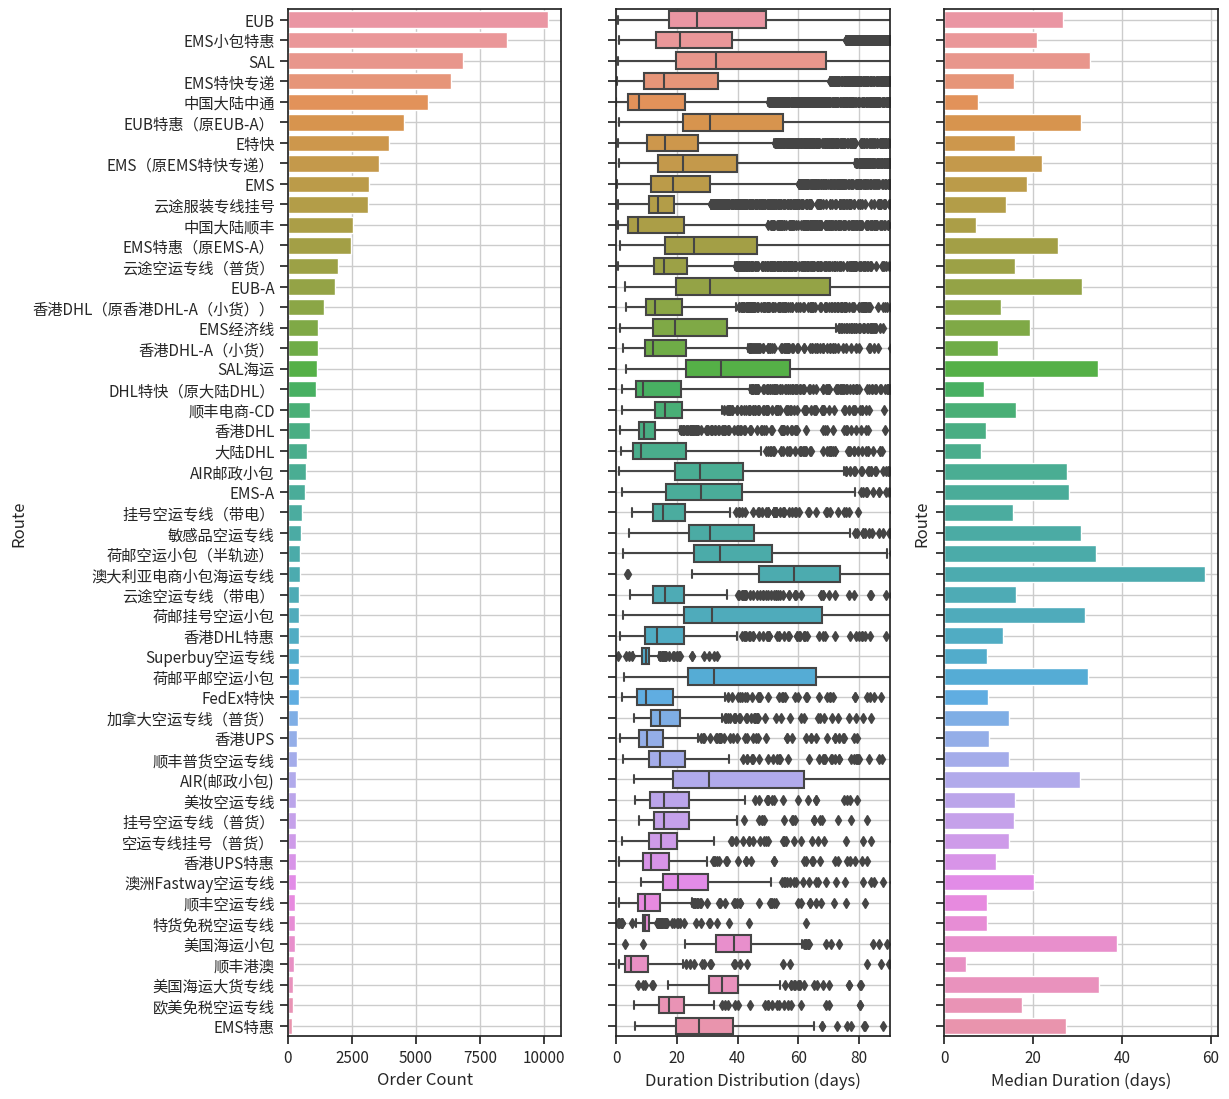

,Route,Order Count,Median Duration (days),95-percentile Duration (days),5-percentile Duration (days),Avg Price (USD/kg)
0,EUB,10167,26.628854,195.883803,11.048147,0.175454
1,EMS小包特惠,8554,20.920660,142.395505,8.071130,0.135519
2,SAL,6853,32.817743,148.957824,12.121315,0.089138
3,EMS特快专递,6358,15.760984,185.986387,5.813586,0.164781
4,中国大陆中通,5481,7.612789,128.097303,2.291366,0.046655
5,EUB特惠（原EUB-A）,4535,30.814630,145.567551,14.211866,0.149564
6,E特快,3958,15.934201,62.015484,6.175343,0.148994
7,EMS（原EMS特快专递）,3568,21.987778,135.233255,7.936212,0.177621
8,EMS,3147,18.637280,73.856627,6.444986,0.171466
9,云途服装专线挂号,3109,13.934340,59.271537,8.125407,0.145923


In [39]:
import datetime
from matplotlib.figure import Figure

from matplotlib.axes import Axes


def route_stats(country: str | None = None, count: int = 30, sort_by: str | None = None, 
                sort_asc: bool = True, filter_routes: list[str] | None = None, min_date: str = '2000-01-01'):
    cdata = data
    if country is not None:
        cdata = [d for d in data if d['area_name'] == country]
        print(f'正在分析送往 {country} 的訂單數據...')
    else:
        print('正在分析送往全球的訂單數據...')

    # Filter by date (convert min_Date to unix seconds first)
    min_date = datetime.datetime.strptime(min_date, '%Y-%m-%d').timestamp()
    cdata = [d for d in cdata if d['package_time'] >= min_date]

    routes = sorted(Counter([d['delivery_name'].strip() for d in cdata]).items(), key=lambda x: -x[1])
    # Filter routes
    if filter_routes is not None:
        routes = [r for r in routes if r[0] in filter_routes]

    print(f'總共有 {len(routes)} 個快遞公司')
    routes = routes[:count]
    count = len(routes)
    print(f'前 {count} 快遞公司的訂單數（圖1）和運輸時間天數（圖2,3）')
    # bars(names)

    df = []
    for route, cnt in routes:
        orders = [d for d in data if d['delivery_name'] == route]
        durations = [d['duration'] for d in orders if d['duration']]
        df.append({
            'Route': route,
            'Order Count': cnt,
            'Median Duration (days)': np.median(durations) if durations else 0,
            '95-percentile Duration (days)': np.percentile(durations, 95) if durations else 0,
            '5-percentile Duration (days)': np.percentile(durations, 5) if durations else 0,
            'Durations': durations,
            'Avg Price (USD/kg)': np.mean([d['real_package_price'] / d['final_weight'] for d in orders if d['final_weight']])
        })
    df = DF(df)

    if sort_by is not None:
        df = df.sort_values(sort_by, ascending=sort_asc)

    fig, ax = plt.subplots(ncols=3, figsize=(12, 8 / 30 * count), sharey='all')
    fig: Figure
    ax: list[Axes]

    sns.barplot(x='Order Count', y='Route', data=df, ax=ax[0], orient='h')
    sns.boxplot(data=df.Durations, ax=ax[1], orient='h')
    sns.barplot(x='Median Duration (days)', y='Route', data=df, ax=ax[2], orient='h')
    ax[1].set_xlabel('Duration Distribution (days)')
    ax[1].set_xlim(0, 90)
    for a in ax:
        a.grid()
    # ax[0].yaxis.set_ticks(list(df.Route))
    plt.show()

    # Delete df['Durations']
    del df['Durations']
    return df


route_stats(count=50)

正在分析送往 加拿大 的訂單數據...
總共有 67 個快遞公司
前 67 快遞公司的訂單數（圖1）和運輸時間天數（圖2,3）


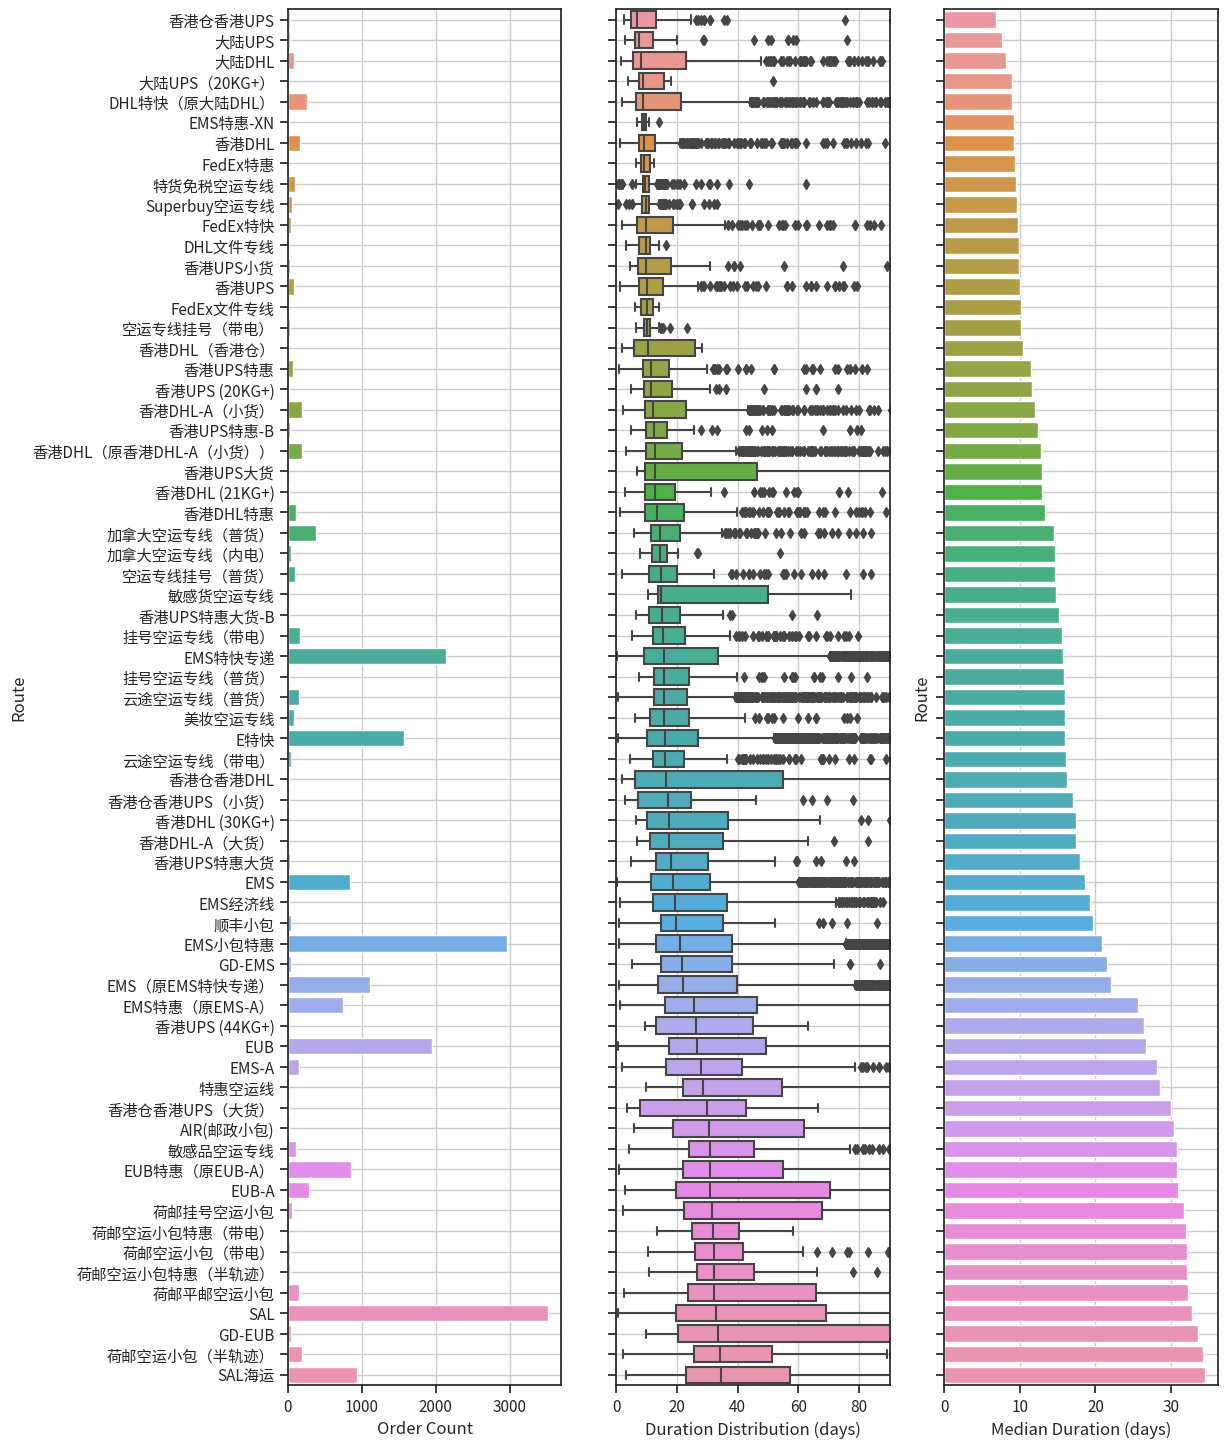

,Route,Order Count,Median Duration (days),95-percentile Duration (days),5-percentile Duration (days),Avg Price (USD/kg)
39,香港仓香港UPS,29,6.829936,95.717656,2.934984,0.328084
38,大陆UPS,29,7.662419,50.449259,3.927633,0.211334
26,大陆DHL,87,8.145127,202.686065,3.891340,0.193983
65,大陆UPS（20KG+）,1,8.899045,36.575749,4.985925,0.107139
12,DHL特快（原大陆DHL）,258,8.939294,128.458690,4.523109,0.214714
...,...,...,...,...,...,...
20,荷邮平邮空运小包,144,32.227610,325.008290,17.209746,0.229572
0,SAL,3521,32.817743,148.957824,12.121315,0.089138
33,GD-EUB,43,33.595706,269.746737,12.395294,0.223721
13,荷邮空运小包（半轨迹）,197,34.194954,152.580457,18.316847,0.255244


In [42]:
route_stats('加拿大', count=70, sort_by='Median Duration (days)')


正在分析送往 美国 的訂單數據...
總共有 5 個快遞公司
前 5 快遞公司的訂單數（圖1）和運輸時間天數（圖2,3）


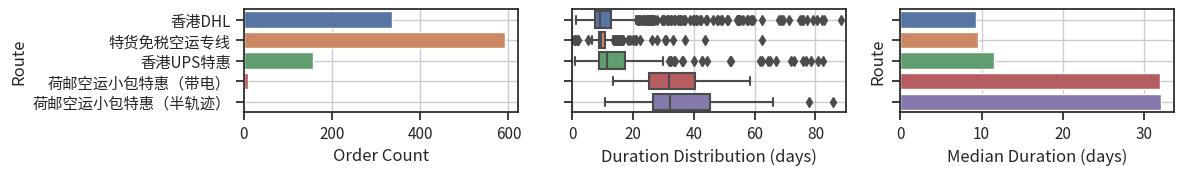

,Route,Order Count,Median Duration (days),95-percentile Duration (days),5-percentile Duration (days),Avg Price (USD/kg)
1,香港DHL,336,9.27,48.94,5.13,0.21
0,特货免税空运专线,591,9.53,18.06,6.99,0.13
2,香港UPS特惠,156,11.51,80.49,6.24,0.17
3,荷邮空运小包特惠（带电）,8,32.00,54.14,19.22,0.24
4,荷邮空运小包特惠（半轨迹）,2,32.13,78.22,18.93,0.23


In [ ]:

route_stats('美国', count=50, sort_by='Median Duration (days)', filter_routes=[
    '特货免税空运专线',
    '香港DHL',
    '香港UPS特惠',
    '荷邮空运小包特惠（带电）',
    '荷邮空运小包特惠（半轨迹）',
], min_date="2023-05-01").round(2)
